In [311]:
from __future__ import division
from time import time
import sqlite3, pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
def hide_spines():
    """Hides the top and rightmost axis spines from view for all active
    figures and their respective axes."""

    # Retrieve a list of all current figures.
    figures = [x for x in matplotlib._pylab_helpers.Gcf.get_all_fig_managers()]
    for figure in figures:
        # Get all Axis instances related to the figure.
        for ax in figure.canvas.figure.get_axes():
            # Disable spines.
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
            ax.spines['left'].set_color('none')
            ax.spines['bottom'].set_color('none')
            # Disable ticks.
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
            
matplotlib.rcParams.update({'font.size': 16})

In [2]:
sqlitefile = '/media/jeroen/886E244A6E24337C/Users/jeroe/Documents/reddit statistics/reddit.sqlite'

<hr>

# Get start & end date of dataset, and number of subreddits

In [45]:
conn = sqlite3.connect(sqlitefile)
c = conn.cursor()
c.execute('''SELECT MIN(created_UTC), MAX(created_UTC), COUNT(DISTINCT subreddit) FROM submissions;''')
rows = c.fetchall()
conn.close()
print rows

[(1138126222, 1441054814, 430434)]


# Get timeline per subreddit

In [35]:
def getRows(start, end):
    conn = sqlite3.connect(sqlitefile)
    c = conn.cursor()
    c.execute('''SELECT subreddit, created_utc FROM submissions WHERE rowid BETWEEN '''+str(start)+''' AND '''+str(end)+''';''')
    rows = c.fetchall()
    conn.close()
    return rows

In [37]:
%%time
data = np.zeros((430435,3507), dtype=np.uint16)
subreddits = {}
steps = int(196.5 / 0.5)
counter = 0
lasttime = time()
for s in range(0,steps):
    start = s*5e5+1
    stop = s*5e5+5e5
    rows = getRows(start,stop)
    for r in rows:
        # find subreddit index
        try:
            subreddit = subreddits[r[0]]
        except KeyError:
            subreddit = counter
            subreddits[r[0]] = subreddit
            counter += 1
        # find which day submissions was made
        day = int((r[1] - 1138057200) / 60/60/24 )
        # 1138057200 is the unix timestamp for January 24, 2006 00:00:00 (UTC),
        # so each bin will contain submissions from 00:00:00 to 23:59:59 for that day in UTC.
        
        data[subreddit,day] += 1
    print 'Processed rows '+str(start)+' till '+str(stop)+' ('+str(stop/1965e5*100)+'%) ('+str(time() - lasttime)+' seconds) subreddit counter: '+str(counter)
    lasttime = time()

Processed rows 1.0 till 500000.0 (0.254452926209%) (4.3712310791 seconds) subreddit counter: 257
Processed rows 500001.0 till 1000000.0 (0.508905852417%) (4.23288488388 seconds) subreddit counter: 776
Processed rows 1000001.0 till 1500000.0 (0.763358778626%) (3.78323698044 seconds) subreddit counter: 2047
Processed rows 1500001.0 till 2000000.0 (1.01781170483%) (4.08506703377 seconds) subreddit counter: 3219
Processed rows 2000001.0 till 2500000.0 (1.27226463104%) (4.57712101936 seconds) subreddit counter: 4235
Processed rows 2500001.0 till 3000000.0 (1.52671755725%) (3.90744113922 seconds) subreddit counter: 5581
Processed rows 3000001.0 till 3500000.0 (1.78117048346%) (5.76671504974 seconds) subreddit counter: 6325
Processed rows 3500001.0 till 4000000.0 (2.03562340967%) (7.30192399025 seconds) subreddit counter: 6895
Processed rows 4000001.0 till 4500000.0 (2.29007633588%) (4.14242601395 seconds) subreddit counter: 7636
Processed rows 4500001.0 till 5000000.0 (2.54452926209%) (4.355

## Make indexed list of subreddits

In [38]:
subreddits_int = np.empty(len(data)+1, dtype=object)
for key, value in subreddits.iteritems():
    subreddits_int[value] = key

## Remove empty rows

In [39]:
inds = np.max(data, axis=1) > 0

In [40]:
data_nonempty = data[inds]
subreddits_int_nonempty = subreddits_int[inds]

/home/jeroen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 430436 but corresponding boolean dimension is 430435
  from ipykernel import kernelapp as app


# Save data to file

In [41]:
# %%time
# np.save('/media/jeroen/886E244A6E24337C/Users/jeroe/Documents/reddit statistics/subreddits_timeline_data.npy', data)
# np.save('/media/jeroen/886E244A6E24337C/Users/jeroe/Documents/reddit statistics/subreddits_timeline_data_nonempty.npy', data_nonempty)
# np.save('/media/jeroen/886E244A6E24337C/Users/jeroe/Documents/reddit statistics/subreddits.npy', subreddits_int)
# np.save('/media/jeroen/886E244A6E24337C/Users/jeroe/Documents/reddit statistics/subreddits_nonempty.npy', subreddits_int_nonempty)
# with open('/media/jeroen/886E244A6E24337C/Users/jeroe/Documents/reddit statistics/subreddits_labels.pkl', 'wb') as f:
#     pickle.dump(subreddits, f)

CPU times: user 7.91 s, sys: 4.55 s, total: 12.5 s
Wall time: 1min 20s


# Load from file

In [2]:
%%time
data = np.load('/media/jeroen/886E244A6E24337C/Users/jeroe/Documents/reddit statistics/subreddits_timeline_data.npy')
subreddits = np.load('/media/jeroen/886E244A6E24337C/Users/jeroe/Documents/reddit statistics/subreddits.npy')
# with open('/media/jeroen/886E244A6E24337C/7C/Users/jeroe/Documents/reddit statistics/subreddits_labels.pkl', 'rb') as f:
#     subreddits = pickle.load(f)

CPU times: user 360 ms, sys: 2.41 s, total: 2.77 s
Wall time: 33.2 s


<hr>

In [3]:
np.where(subreddits == 'pics')

(array([47]),)

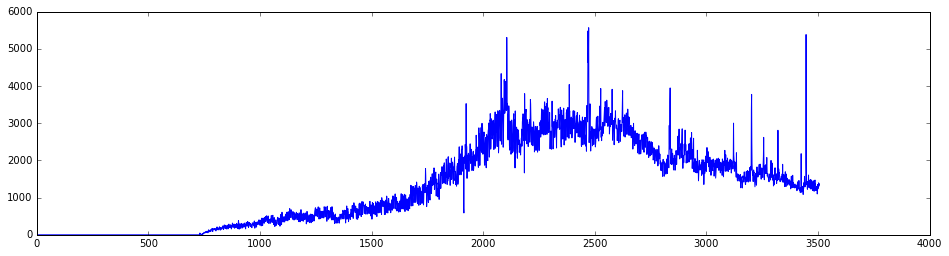

In [4]:
plt.figure(figsize=(16,4))
plt.plot(data[47])

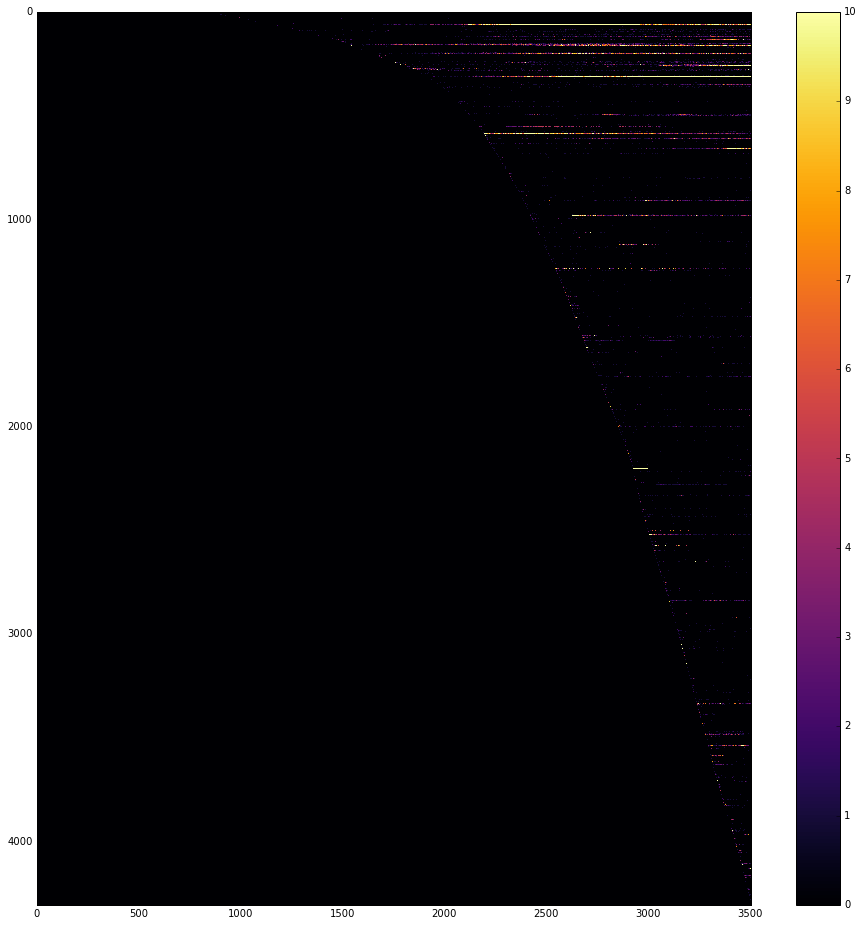

CPU times: user 1.62 s, sys: 300 ms, total: 1.92 s
Wall time: 1.93 s


In [5]:
%%time
plt.figure(figsize=(16,16))
plt.imshow(data[::100], aspect='auto', interpolation='nearest', cmap='inferno', vmax=10)
plt.colorbar()
plt.show()

## Correlation matrix

In [48]:
%%time
corrs = np.corrcoef(data[::100])

CPU times: user 8.82 s, sys: 212 ms, total: 9.04 s
Wall time: 5.11 s


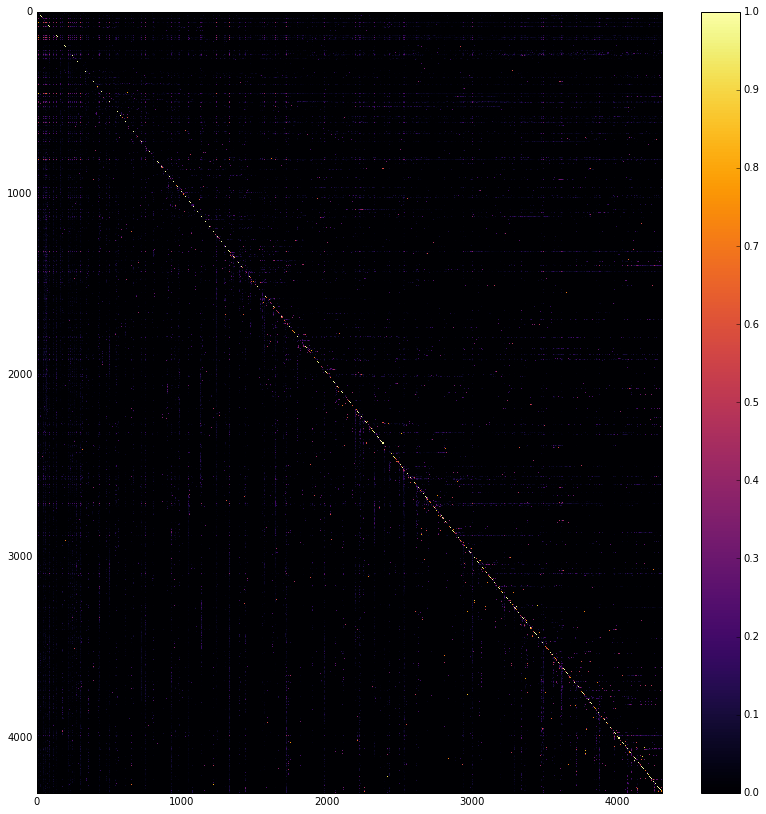

In [49]:
plt.figure(figsize=(14,14))
plt.imshow(corrs, vmin=0, vmax=1, aspect='auto', interpolation='nearest', cmap='inferno')
plt.colorbar()
plt.show()

# Map subreddits to video pixels

In [3]:
# 1:1

offset = 26
field = np.zeros((658+offset,658))
# field = np.zeros((720,1280)) # 1:1 square in 16:9 frame
# spawn = [int(field.shape[0]/2), int(field.shape[1]/2)] # center
spawn = [int(field.shape[0]/2) + int(offset/2), int(field.shape[1]/2)] # center with offset

path = np.zeros((430435, 2), dtype=np.uint16)
path[0] = spawn
here = spawn
wantToGo = 'right'
for i in range(1,len(path)):
    try:
        if wantToGo == 'right':
            if field[here[0]+1, here[1]] == 0:
                here[0] += 1
                wantToGo = 'down'
            else:
                here[1] -= 1
        elif wantToGo == 'down':
            if field[here[0], here[1]+1] == 0:
                here[1] += 1
                wantToGo = 'left'
            else:
                here[0] += 1
        elif wantToGo == 'left':
            if field[here[0]-1, here[1]] == 0:
                here[0] -= 1
                wantToGo = 'up'
            else:
                here[1] += 1
        elif wantToGo == 'up':
            if field[here[0], here[1]-1] == 0:
                here[1] -= 1
                wantToGo = 'right'
            else:
                here[0] -= 1

        field[here[0], here[1]] = i
        path[i] = here
    except IndexError:
        rest = np.zeros((656,2))
        rest[:,1] = range(656)
        path[i:] = rest
        break

In [9]:
# # 16:9

# field = np.zeros((720,1280))
# # spawn = [int(field.shape[0]/2), int(field.shape[1]/2)] # center
# spawn = [0,0]

# path = np.zeros((1280*720, 2), dtype=np.uint16)
# path[0] = spawn
# here = spawn
# headed = 'down'
# for i in range(1,len(path)):
#     if headed == 'down':
#         try:
#             a = field[here[0], here[1]+1]
#             if a==0:
#                 here[1] += 1
#             else:
#                 headed = 'right'
#                 here[0] += 1
#         except IndexError:
#             headed = 'right'
#             here[0] += 1
#     elif headed == 'right':
#         try:
#             a = field[here[0]+1, here[1]]
#             if a==0:
#                 here[0] += 1
#             else:
#                 headed = 'up'
#                 here[1] -= 1
#         except IndexError:
#             headed = 'up'
#             here[1] -= 1
#     elif headed == 'up':
#         if here[1]-1 > 0:
#             a = field[here[0], here[1]-1]
#             if a==0:
#                 here[1] -= 1
#             else:
#                 headed = 'left'
#                 here[0] -= 1
#         else:
#             headed = 'left'
#             here[0] -= 1
#     elif headed == 'left':
#         if here[0]-1 > 0:
#             a = field[here[0]-1, here[1]]
#             if a==0:
#                 here[0] -= 1
#             else:
#                 headed = 'down'
#                 here[1] += 1
#         else:
#             headed = 'down'
#             here[1] += 1
#     field[here[0], here[1]] = i
#     path[i] = here

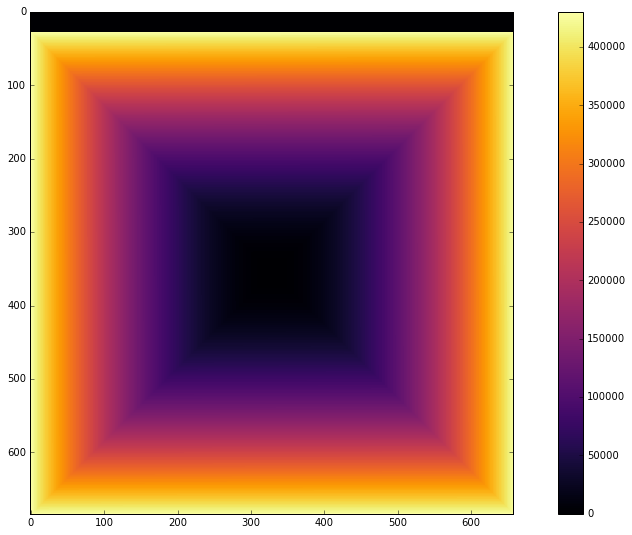

In [4]:
plt.figure(figsize=(16,9))
plt.imshow(field, cmap='inferno', interpolation='nearest')
plt.colorbar()

In [5]:
data.shape

(430435, 3507)

### Get timestamp per frame

In [5]:
%%time
import datetime
dates = []
for i in range(data.shape[1]):
    d = datetime.datetime.fromtimestamp(1138057200+60*60*24*i)
    dates.append(d.strftime('%Y-%m-%d'))

CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 94.8 ms


### Get total subreddit count per frame

In [6]:
%%time
subreddit_count = np.zeros(data.shape[1], dtype=int)
subreddit_count[0] = len(np.where(data[:,0])[0])
for i in range(1,data.shape[1]):
    x = data[subreddit_count[i-1]:,i]
    new_subs = np.where(x>0)[0]
    if len(new_subs) < 1:
        new_subs = 0
    else:
        new_subs = new_subs[-1]
    subreddit_count[i] = subreddit_count[i-1] + new_subs
    
    if i%1000==0:
        print i

1000
2000
3000
CPU times: user 27 s, sys: 0 ns, total: 27 s
Wall time: 26.9 s


In [8]:
np.max(subreddit_count)

430434

# Save frames

In [9]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

In [30]:
%%time
cmap = plt.get_cmap('inferno')
for i in range(629,data.shape[1]):
    frame = np.zeros((658+offset,658), dtype=np.uint8)
    
    for j,x in enumerate((data[:,i].clip(0, 10)*(255/10)).astype(np.uint8)):
        frame[path[j,0], path[j,1]] = x
        
    frame = np.delete(cmap(frame, bytes=True), 3, 2) # create rgba, delete alpha channel
    
    img = Image.fromarray(frame)
    draw = ImageDraw.Draw(img)
    # font = ImageFont.truetype(<font-file>, <font-size>)
    font = ImageFont.truetype("usr/share/fonts/truetype/freefont/FreeMono.ttf", 20)
    # draw.text((x, y),"Sample Text",(r,g,b))
    
    # add timestamp
    draw.text((6, 3), dates[i], (255,255,255),font=font)
    # add subreddit counter
    draw.text((450, 3), str(subreddit_count[i]).rjust(6)+' subreddits', (255,255,255),font=font)
    
    img.save('frames/'+str(i-629).zfill(4)+'.png')

CPU times: user 17min 59s, sys: 6.2 s, total: 18min 5s
Wall time: 18min 4s


# Frequency analysis

In [285]:
data_mean = np.mean(data[:,629:], axis=0)
print data_mean.shape

(2878,)


In [290]:
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

In [294]:
import datetime
dates = []
for i in range(data.shape[1]):
    d = datetime.datetime.fromtimestamp(1138057200+60*60*24*i)
    dates.append(d)
dates = np.array(dates)[629:]

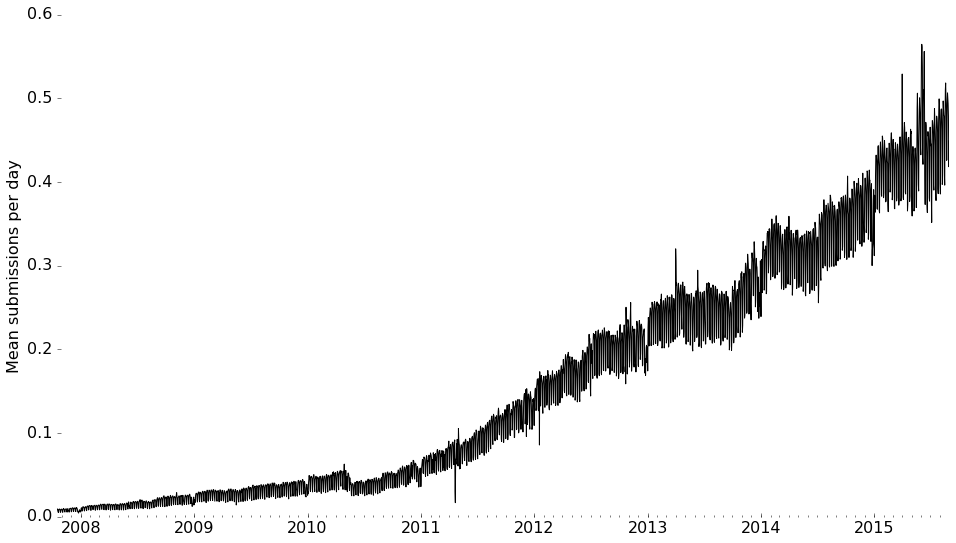

In [312]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(dates, data_mean, color='black')
ax.set_ylabel('Mean submissions per day')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

hide_spines()
plt.show()

In [230]:
from scipy.signal import periodogram

/home/jeroen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide


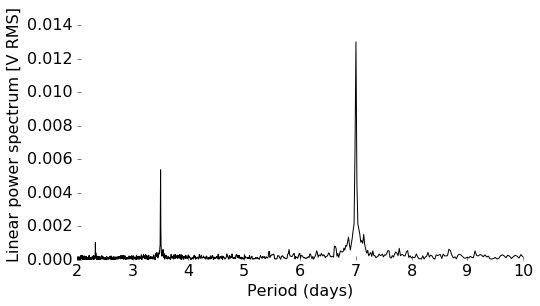

In [322]:
f, Pxx_spec = periodogram(data_mean, scaling='spectrum', detrend='linear')
plt.figure(figsize=(16/2,9/2))
ax = plt.subplot(111)
ax.plot(1/f, np.sqrt(Pxx_spec), color='black')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Linear power spectrum [V RMS]')
plt.ylim([0,0.015])
plt.xlim([2,10])

hide_spines()

plt.show()

# Activity per day of the week

In [222]:
dates[629]

'2007-10-15'

In [226]:
d = datetime.date(2007,10,15)
print d.isoweekday() # 1 == Monday

1


In [259]:
weekday_activity = np.zeros(7)
for i in range(7):
    weekday_activity[i] = np.sum(data[:,629+i:][:,::7])
# normalize
weekday_activity = weekday_activity / np.sum(data[:,629:]) * 100

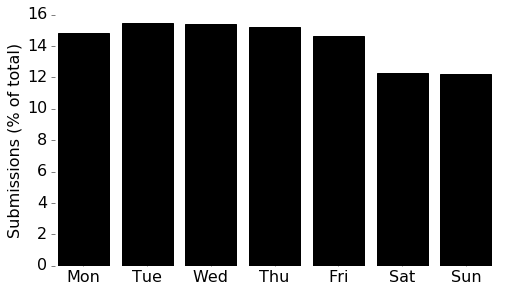

In [334]:
labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(16/2,9/2))
plt.bar(range(7), weekday_activity, align='center', color='black')
plt.xticks(range(7), labels)
plt.ylabel('Submissions (% of total)')
plt.xlim([-0.5, 6.5])

hide_spines()

plt.show()

# Find interesting subreddits

2015-06-03

In [101]:
import time
import datetime
d = datetime.date(2014,12,21)

unixtime = time.mktime(d.timetuple())
ind = int(round((unixtime - 1138057200)/60/60/24))
print ind
print dates[ind]

3253
2014-12-21


In [102]:
frame = np.zeros((658+offset,658), dtype=np.uint8)
    
for j,x in enumerate((data[:,ind].clip(0, 10)*(255/50)).astype(np.uint8)):
    frame[path[j,0], path[j,1]] = x

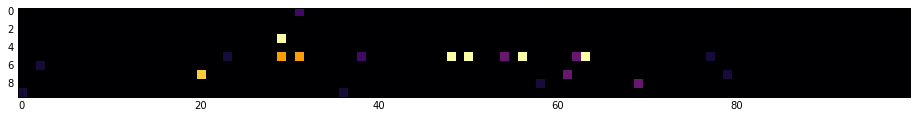

In [103]:
plt.figure(figsize=(16,9))
plt.imshow(frame[110:120,500:600], cmap='inferno', interpolation='nearest')

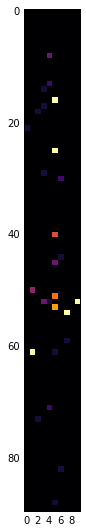

In [104]:
plt.figure(figsize=(16,9))
plt.imshow(frame[110:200,565:575], cmap='inferno', interpolation='nearest')

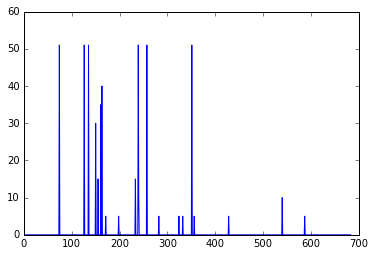

In [105]:
plt.plot(frame[:,570])

In [108]:
ind = np.where(frame[:,570] >= 30)
ind[0]

array([ 74, 126, 135, 150, 161, 163, 239, 257, 351])

In [109]:
frame[:,570][ind]

array([51, 51, 51, 30, 35, 40, 51, 51, 51], dtype=uint8)

In [96]:
a = np.argmax(frame[:,570])
for i,p in enumerate(path):
        if p[0] == a and p[1] == 570:
            print subreddits[i]

celebsunleashed


In [100]:
for d in ind[0]:
    for i,p in enumerate(path):
        if p[0] == d and p[1] == 570:
            print subreddits[i]

celebsunleashed
MarioJenkins
ChristineHolloway
JohnCannon
HollyKennedy
KateNguyen
JenniferGray
OmoniyiJulien
UkrainianConflict
AgMarketplace


# Giant timeline image

In [3]:
# data8bit = np.zeros_like(data, dtype=np.uint8)
# for i,d in enumerate(data):
#     data8bit[i] = (d.clip(0,50)*(255/50)).astype(np.uint8)

In [4]:
# %%time
# np.save('/media/jeroen/886E244A6E24337C/Users/jeroe/Documents/reddit statistics/timeline_8bit.npy', data8bit[:,629:])

CPU times: user 38.1 s, sys: 1.49 s, total: 39.6 s
Wall time: 49.4 s


In [3]:
%%time
data8bit = np.load('/media/jeroen/886E244A6E24337C/Users/jeroe/Documents/reddit statistics/timeline_8bit.npy')

CPU times: user 44 ms, sys: 988 ms, total: 1.03 s
Wall time: 12.9 s


In [7]:
data8bit = data8bit[::-1]

In [4]:
from skimage.measure import block_reduce

In [6]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

In [5]:
data8bit.shape

(430435, 2878)

In [15]:
data8bit = block_reduce(data8bit, (100,1), func=np.max)

In [16]:
data8bit.shape

(4305, 2878)

In [7]:
cmap = plt.get_cmap('inferno')

In [8]:
data8bit = np.delete(cmap(data8bit, bytes=True), 3, 2) # create rgba, delete alpha channel

In [18]:
img = Image.fromarray(data8bit)

In [19]:
img.save('timeline_downsampled100x_max50_grey.png')

# Save full resolution over several images

In [16]:
i=10000
while not len(data8bit)%i==0:
    i-=1
print i

2777


In [17]:
len(data8bit)/2777

155.0

In [28]:
cmap = plt.get_cmap('inferno')
for i in np.linspace(0, data8bit.shape[0], 156, dtype=int):
    d = data8bit[i:i+2777]
    d = np.delete(cmap(d, bytes=True), 3, 2) # create rgba, delete alpha channel
    img = Image.fromarray(d)
    img.save('full res/'+str(i).zfill(6)+'-'+str(i+2777).zfill(6)+'.png')

ValueError: tile cannot extend outside image

<hr>

In [7]:
import os
for i,x in enumerate(sorted(os.listdir('full res/'))):
#     print '''<img id='img'''+str(i)+'''', width=2777 height=2878 src='data:image/gif;base64,R0lGODlhAQABAIAAAAAAAP///yH5BAEAAAAALAAAAAABAAEAAAIBRAA7'>'''
    print '"full res/'+x+'",'

"full res/000000-002777.png",
"full res/002777-005554.png",
"full res/005554-008331.png",
"full res/008331-011108.png",
"full res/011108-013885.png",
"full res/013885-016662.png",
"full res/016662-019439.png",
"full res/019439-022216.png",
"full res/022216-024993.png",
"full res/024993-027770.png",
"full res/027770-030547.png",
"full res/030547-033324.png",
"full res/033324-036101.png",
"full res/036101-038878.png",
"full res/038878-041655.png",
"full res/041655-044432.png",
"full res/044432-047209.png",
"full res/047209-049986.png",
"full res/049986-052763.png",
"full res/052763-055540.png",
"full res/055540-058317.png",
"full res/058317-061094.png",
"full res/061094-063871.png",
"full res/063871-066648.png",
"full res/066648-069425.png",
"full res/069425-072202.png",
"full res/072202-074979.png",
"full res/074979-077756.png",
"full res/077756-080533.png",
"full res/080533-083310.png",
"full res/083310-086087.png",
"full res/086087-088864.png",
"full res/088864-091641.png",
"full res/

In [5]:
import os
for i,x in enumerate(sorted(os.listdir('full res/'))):
    print 'var img'+str(i)+' = new Image();'
    print 'img'+str(i)+'.src = "file:///home/jeroen/Documents/code/reddit statistics/subreddits activity/full res/'+x+'";'

var img0 = new Image();
img0.src = "file:///home/jeroen/Documents/code/reddit statistics/subreddits activity/full res/000000-002777.png";
var img1 = new Image();
img1.src = "file:///home/jeroen/Documents/code/reddit statistics/subreddits activity/full res/002777-005554.png";
var img2 = new Image();
img2.src = "file:///home/jeroen/Documents/code/reddit statistics/subreddits activity/full res/005554-008331.png";
var img3 = new Image();
img3.src = "file:///home/jeroen/Documents/code/reddit statistics/subreddits activity/full res/008331-011108.png";
var img4 = new Image();
img4.src = "file:///home/jeroen/Documents/code/reddit statistics/subreddits activity/full res/011108-013885.png";
var img5 = new Image();
img5.src = "file:///home/jeroen/Documents/code/reddit statistics/subreddits activity/full res/013885-016662.png";
var img6 = new Image();
img6.src = "file:///home/jeroen/Documents/code/reddit statistics/subreddits activity/full res/016662-019439.png";
var img7 = new Image();
img7.src =